In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools


def visualize_top_k_accuracy(accs):
    colors = itertools.cycle(['b', 'g', 'c', 'm', 'y', 'k'])
    max_x = max([max(k for k, _ in acc) for acc, _ in accs])
    for acc, name in accs:
        k, accuracy = zip(*acc)
        accuracy_percentage = [a * 100 for a in accuracy]  # Convert to percentage

        plt.plot(k, accuracy_percentage, color=next(colors))
        plt.xlabel('k')
        plt.ylabel('Top-k Accuracy (%)')
        plt.title('Top-k Accuracy')
        
    # Add a horizontal red dashed line at 100%
    plt.axhline(y=100, color='r', linestyle='--', label='100% Accuracy')

    plt.xticks(range(1, max_x + 1))
    # Show the legend
    plt.legend([name for _, name in accs])

    # Display the plot
    # plt.grid(True)
    plt.show()


def topk_accuracy(df, max_k=100):
    temp = -1
    k_acc = []
    for k in range(1, max_k + 1):
        top_k_conditions = [(df[f'top{rank}_text'] == df['answer_text']) for rank in range(1, k + 1)]
        top_k_accuracy = (df['correct'] & pd.concat(top_k_conditions, axis=1).any(axis=1)).mean()
        if top_k_accuracy != temp:
            k_acc.append((k, top_k_accuracy))
            temp = top_k_accuracy
        if top_k_accuracy == 1.0:
            break
    else:
        # 루프가 100%에 도달하지 못했을 경우 마지막 accuracy
        k_acc.append((k, top_k_accuracy))
        
    return k_acc

        
def topk_accuracy_fixed(df, topk=[1, 2, 3, 5, 10]):
    max_topk=(len(df.columns) - 3) // 2
    k_acc = []
    for k in range(1, max_topk + 1):
        # 각 k에 대해 모든 row에 대해 top_k 조건을 계산
        top_k_conditions = [(df[f'top{rank}_text'] == df['answer_text']) for rank in range(1, k + 1)]
        top_k_accuracy = (df['correct'] & pd.concat(top_k_conditions, axis=1).any(axis=1)).mean()

        # topk 리스트에 있는 값이 나오면 k_acc에 추가
        if k in topk:
            k_acc.append((k, top_k_accuracy))

        # top_k_accuracy가 1.0이면 k_acc에 추가하고 루프 종료
        if top_k_accuracy == 1.0:
            k_acc.append((k, top_k_accuracy))
            break

    return k_acc


def update_correct_column(df, k):
    # correct 열을 업데이트할 새로운 리스트를 만듦
    df = df.copy()
    updated_correct = []
    
    for idx, row in df.iterrows():
        found_correct = False
        
        # top-k 범위 내에서 answer_text와 일치하는지 확인
        for rank in range(1, k + 1):
            if row[f'top{rank}_text'] == row['answer_text']:
                found_correct = True
                break
        
        # 맞춘 경우 'correct', 아니면 'false' 추가
        if found_correct:
            updated_correct.append('correct')
        else:
            updated_correct.append('false')
    
    # correct 열 업데이트
    df['correct'] = updated_correct
    df_false = df[df['correct'] == 'false']
    
    return df_false


def print_false_answers(df, print_k=5):
    for idx, row in df.iterrows():
        print(f"query: {row['query']}")
        print(f"answer: {row['answer_text']}")
        print()
        for k in range(1, print_k + 1):
            print(f"top {k}: {row[f'top{k}_text'][:200]}")        
        print()
        print()

In [7]:
e5_mistral = pd.read_csv('../data/experiments/e5-mistral_topn.csv')
mul_e5_max = pd.read_csv('../data/experiments/multilang-e5_max_pooling.csv')
mul_e5_mean = pd.read_csv('../data/experiments/multilang-e5_mean_pooling.csv')
koe5_mean = pd.read_csv('../data/experiments/KoE5_mean_pooling.csv')
koe5_max = pd.read_csv('../data/experiments/KoE5_max_pooling.csv')
KoE5_mean_pooling_all_queries = pd.read_csv('../data/experiments/KoE5_mean_pooling_all_queries.csv')

In [8]:
# calculate_top_k_accuracy(df, max_k=10)
k_acc = topk_accuracy_fixed(KoE5_mean_pooling_all_queries, topk=[1,2,3,5,10,15,20,25,30,35])
for k, acc in k_acc:
    print(f"Top {k} Accuracy: {acc * 100:.2f} %")

Top 1 Accuracy: 42.60 %
Top 2 Accuracy: 55.61 %
Top 3 Accuracy: 61.64 %
Top 5 Accuracy: 68.03 %
Top 10 Accuracy: 74.43 %
Top 15 Accuracy: 77.39 %
Top 20 Accuracy: 79.51 %
Top 25 Accuracy: 81.13 %
Top 30 Accuracy: 82.40 %
Top 35 Accuracy: 83.33 %


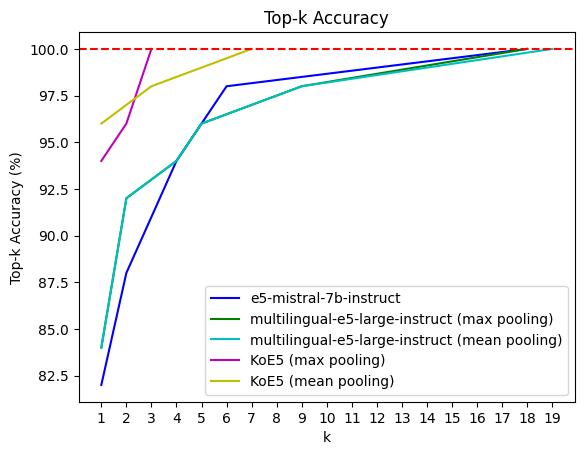

In [52]:
accs = [(topk_accuracy(e5_mistral), 'e5-mistral-7b-instruct'),
        (topk_accuracy(mul_e5_max), 'multilingual-e5-large-instruct (max pooling)'),
        (topk_accuracy(mul_e5_mean), 'multilingual-e5-large-instruct (mean pooling)'),
        (topk_accuracy(koe5_mean), 'KoE5 (max pooling)'),
        (topk_accuracy(koe5_max), 'KoE5 (mean pooling)'),
        ]
visualize_top_k_accuracy(accs)